<h1><center>STAT/CSE 416 Section 3: Logistic Regression</center></h1>
<center><b>Section:</b>AA/AB BA/BB</center>
<center><b>Instructor:</b>Emilija Perković</center>
<center><b>TA:</b>Octavian-Vlad Murad</center>
<center><b>Date:</b>January 25, 2023</center>

*Adapted from slides and notebooks from STAT/CSE 416 Spring 2020 TAs.*

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.linear_model import LogisticRegression # import logistic regression model
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', 
                                             [(0, '#3A81BA'),
                                              (0.5, '#FFFFFF'),
                                              (1, '#D89F39')])

# Sigmoid function 
The definition of sigmoid/logistic function is as following:
$$
S(x) = \frac{1}{1 + \exp(-x)} = \frac{\exp(x)}{1 + \exp(x)}
$$


In [14]:
def sigmoid_function(x):
  return 1. / (1. + np.exp(-x))

Text(0, 0.5, 'S(x)')

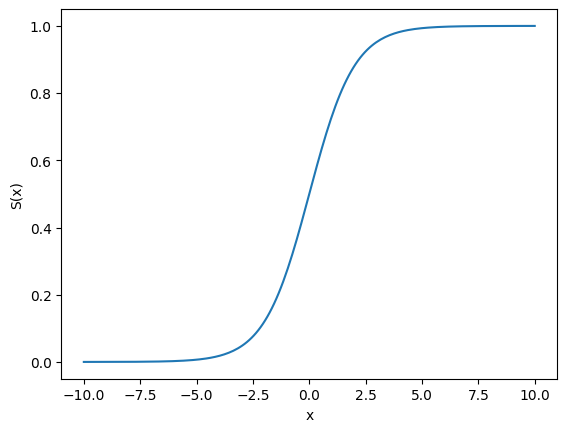

In [15]:
x = np.linspace(-10, 10, 200)
plt.plot(x, sigmoid_function(x))
plt.xlabel('x')
plt.ylabel('S(x)')

# Some nice properties of sigmoid function


1.   It is monotone increasing in $x$.
2.   The function value is always between [0,1], thus perfect for modeling probabilities.


# Logistic Regression

Data: $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$ where $x_i \in \mathbb{R}^k$ and $y_i \in \{-1, +1\}$. 

Logistic regression uses sigmoid function to estimate the probability of $y_i = +1$. 
$$
P(y_i = +1 | x_i, \beta) = \frac{1}{1 + \exp(-x_i^T \beta)} = \frac{\exp(x_i^T \beta)}{1 + \exp(x_i^T \beta)} = S(x_i^T \beta)
$$
what about the probability of $y_i = -1$?
$$
P(y_i = -1 | x_i, \beta) = \frac{1}{1 + \exp(x_i^T \beta)} = \frac{\exp(-x_i^T \beta)}{1 + \exp(-x_i^T \beta)} = 1 - S(x_i^T \beta)
$$
Check it yourself that the above expressions are correct. 


# Logistic Regrssion: Using the model for classification

1. Use data to "get" an optimal estimate of parameter $\hat{\beta}$,  we will talk about how to estimate the parameter later .
2. Given an new input $x$, estimate the probability of $y$ being +1:
$$
P(y = +1 |x, \hat{\beta}) = 1 / (1 + \exp(-x^T \hat{\beta}))
$$
3. Pick a threshold, say $0.5$,
$$
\hat{y} = \begin{cases} 
+1 & \text{if } P(y = +1 | x, \hat{\beta}) \geq 0.5 \\
-1 & \text{otherwise}
\end{cases}
$$

**Note that the threshold does not need to be fixed as 0.5**. The choice really depend on the specific problem and what you care about. In the example with medical diagnostics for cancer, a lower threshold is usually preferred so a patient with cancer would be more likely discovered. For the example with spam email detection, a higher threshold is probably better so an important email would be less likely to be classified as spam.

# Logistic Regression:  Maximum likelihood estimation of $\beta$

The quality metric we use to evaluate how good a set of parameters $\beta$ is the **likelihood function**(or simply **likelihood**).

The likelihood is defined as:
$$
L_n(\beta) = \prod_{i=1}^n P(y_i | x_i, \beta)
$$
And the log-likelihood looks like following:
$$
l_n(\beta) = \log(L_n(\beta)) = \sum_{i=1: y_i = +1}^n \ln\left(\frac{1}{1 + \exp(-x_i^T\beta)}\right) + \sum_{i=1:y_i = -1}^n \ln \left(\frac{1}{1 + \exp(x_i^T \beta)} \right)
$$
where we split the summation into positive and negative samples. 

## Motivation for using likelihood:
In linear regression, we minimized the RSS. Similarly, we could minimize the classification error:
$$
\hat{\beta} = \arg\min_w \frac{1}{n} \sum_{i=1}^n I(y_i \neq \hat{y}_i)
$$
This loss function is inituitive, but very hard to optimize with respect to $\beta$. Thus, we choose the MLE as a quality metric because it leads to a much more tractable optimization problem.

## Likelihood:
For logistic regression, given a data point $(x_i, y_i)$, assuming that $y_i = +1$, then likelihood for this single data point would be 
$$
l(\beta) = P(y = +1 | x; \beta) = \frac{1}{1 + \exp(-x^T \beta)}
$$
notice that we usually view the above probility as a function of features/input $x$. However, when talking about likelihood, the data is considered fixed, and the likelihood is viewed as a function of the parameter $\beta$. The idea for maximum likelihood estimation is that we would like our parameter $\beta$ to maximize the above probability. A larger probability indicates a better fit of our model.  

Assuming that the data points are sampled independently and that they are identically distributed, the joint likelihood is simply defined as the product of the likelihood for each individual data point. We usually maximize the log of the likelihood for computational reasons. The maximizer would be the same since log is a monotone function.

# How `sklearn` works in the background
For linear regression, we were able to find the parameters of the model in a closed form by using the sufficient statistics or by minimizing the RSS objective with gradient descent. **For logistic regression, there is no closed form solution**, so we must resort to gradient-based methods like gradient ascent (ascent because we're trying to maximize the log likelihood instead of minimize) to solve the problem. You could implement logistic regression yourself by calculating the gradient of the log likelihood $\nabla l(\beta)$ and applying our update rule $\beta\leftarrow \beta + \eta \nabla l(\beta)$ (we would use + instead of - because we're trying to maximize) until convergence. The log likelihood function is *concave* with respect to $\beta$, so with the appropriate learning rate and enough iterations, we will converge to the right answer.

`sklearn.linear_model.LogisticRegression` takes in a `solver` parameter which determines how it will find $\beta$. Though the different solvers have advantages and disadvantages based on the problem, they all use local information (like the gradient) to try and find the optimum.


## Example:

In [16]:
# data
x_1, y_1 = (0.5, 0.75), 1
x_2, y_2 = (-1, 0.33), -1
x_3, y_3 = (0.5, -0.75), -1
x_4, y_4 = (-0.5, -0.66), 1

X = np.array([x_1, x_2, x_3, x_4])
Y = np.array([y_1, y_2, y_3, y_4])

# raw data is not linearly separable in 2d
X_not_sep = X.copy()
# raw data + a new feature to make the data linearly separable in 3d
X_sep = np.concatenate([X, (X[:, 0] * X[:, 1]).reshape(-1, 1)], axis=1)

In [17]:
X

array([[ 0.5 ,  0.75],
       [-1.  ,  0.33],
       [ 0.5 , -0.75],
       [-0.5 , -0.66]])

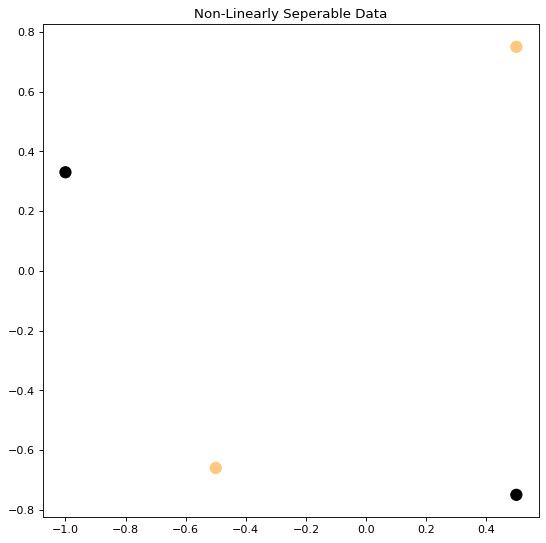

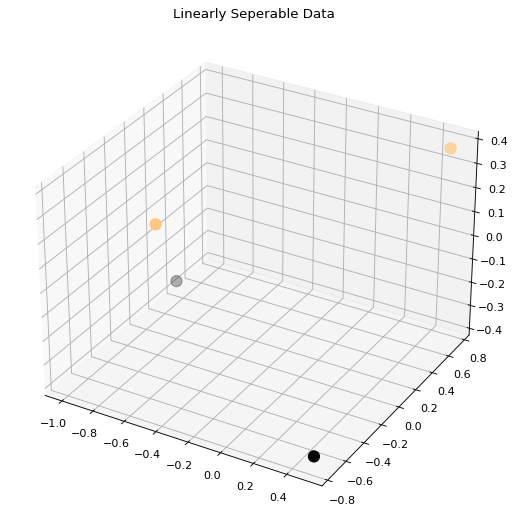

In [18]:
# data is not linearly separable in 2d
plt.figure(figsize=(8, 8), dpi=80)
plt.title('Non-Linearly Seperable Data')
plt.scatter(X_not_sep[:, 0], X_not_sep[:, 1], c=Y, cmap="copper", s=100)

#but it is in 3d
plt.figure(figsize=(8, 8), dpi=80)
ax = plt.axes(projection="3d")
plt.title('Linearly Seperable Data')
ax.scatter(X_sep[:, 0], X_sep[:, 1], X_sep[:, 2], c=Y, cmap="copper", s=100)

In [19]:
# Compute the log likelihood for logistic regression
# Go term by term for clarity
def logistic_log_likelihood(beta_0, beta_1):
  l_1 = sigmoid_function(beta_0 * x_1[0] + beta_1 * x_1[1]) # w^Tx
  l_2 = 1 - sigmoid_function(beta_0 * x_2[0] + beta_1 * x_2[1])
  l_3 = 1 - sigmoid_function(beta_0 * x_3[0] + beta_1 * x_3[1])
  l_4 = sigmoid_function(beta_0 * x_4[0] + beta_1 * x_4[1])
  return np.log(l_1) + np.log(l_2) + np.log(l_3) + np.log(l_4)

d:\cse 416\env\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[[0.5927142  0.63832004]]
MLE estimate: [0.5927142  0.63832004]


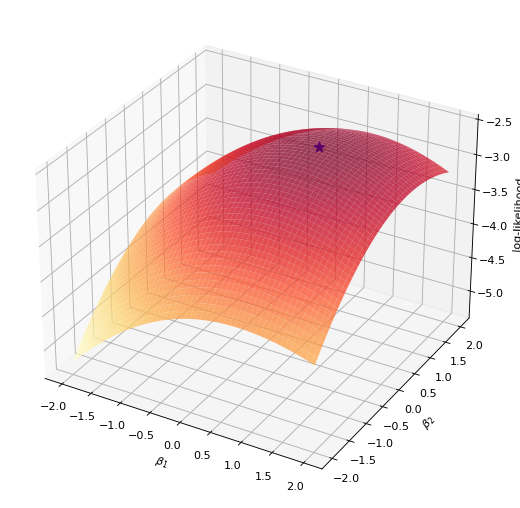

In [20]:
# train a Log. Reg. model using the 2d data
model = LogisticRegression(penalty = 'none', fit_intercept=False) 
model.fit(X_not_sep, Y)

mle_estimate = model.coef_[0]
print(model.coef_)
# Plot the likelihood function surface and the MLE.
beta_1 = np.linspace(-2, 2, 200)
beta_2 = np.linspace(-2, 2, 200)
beta_1, beta_2 = np.meshgrid(beta_1, beta_2) 
loglik = logistic_log_likelihood(beta_1, beta_2)

fig = plt.figure(figsize=(8, 8), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(beta_1, beta_2, loglik, alpha=0.75, cmap='YlOrRd')
ax.scatter(mle_estimate[0], mle_estimate[1], 
           logistic_log_likelihood(mle_estimate[0], mle_estimate[1]), c='blue',
           s=100, marker='*', alpha=1)
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
ax.set_zlabel('log-likelihood')

print("MLE estimate:", mle_estimate)

Estimate of the parameter would be:

$\hat{\beta}_1 = 0.593$, $\hat{\beta}_2 = 0.638$

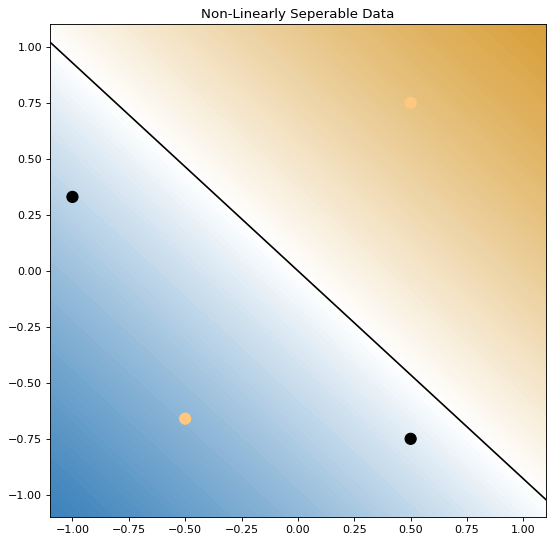

In [21]:
# plot the decision boundary

xs = np.linspace(-1.1, 1.1, 200)
ys = np.linspace(-1.1, 1.1, 200)

xx, yy = np.meshgrid(xs, ys)
probs = sigmoid_function(xx.ravel() * mle_estimate[0] + yy.ravel() * mle_estimate[1])

plt.figure(figsize=(8, 8), dpi=80)
plt.title('Non-Linearly Seperable Data')
plt.contourf(xx, yy, probs.reshape(xx.shape), cmap=cmap, levels=126) # map colours
plt.scatter(X_not_sep[:, 0], X_not_sep[:, 1], c=Y, cmap="copper", s=100, alpha=1) # map points
plt.plot(xs, -xs * mle_estimate[0]/mle_estimate[1], color='black') # map the boundary line

plt.show()

In [22]:
# train a Log. Reg. model using the 3d data

model = LogisticRegression(penalty = 'none', fit_intercept=False) 
model.fit(X_sep, Y)

mle_estimate = model.coef_[0]

print("MLE estimate:", mle_estimate)

MLE estimate: [ 0.28010003 -0.61262973 27.73360071]


d:\cse 416\env\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Estimate of the parameter would be:

$\hat{\beta}_1 = 0.2801$, $\hat{\beta}_2 = -0.6126$, $\hat{\beta}_3 = 27.7336$

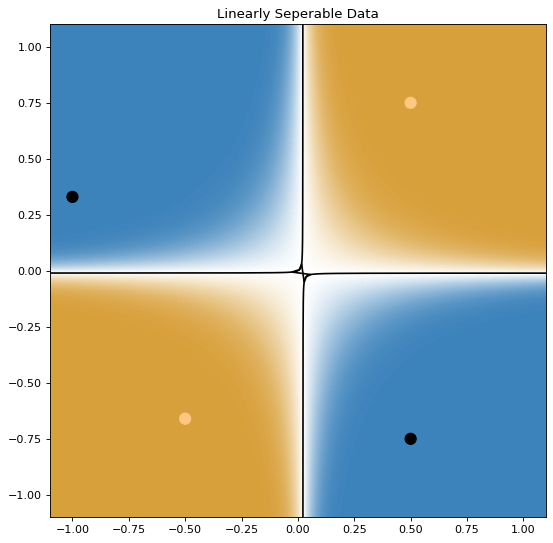

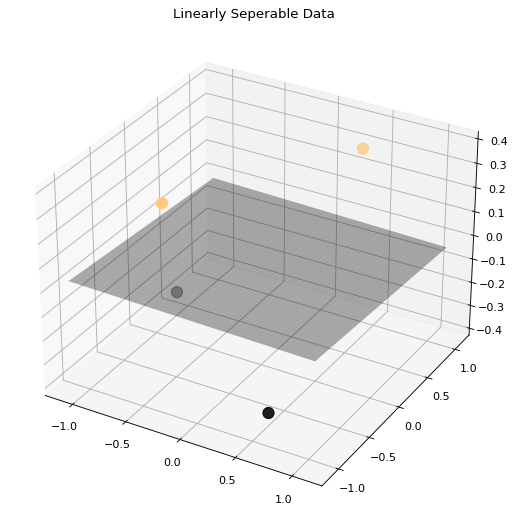

In [23]:
# plot of the decision boundary both in 2d and in 3d. Note that the decision boundary is no longer linear in 2d
# but that it still is in 3d.
xs = np.linspace(-1.1, 1.1, 200)
ys = np.linspace(-1.1, 1.1, 200)

xx, yy = np.meshgrid(xs, ys)
probs = sigmoid_function(xx.ravel() * mle_estimate[0] + yy.ravel() * mle_estimate[1] + xx.ravel() * yy.ravel() * mle_estimate[2])

plt.figure(figsize=(8, 8), dpi=80)
plt.title('Linearly Seperable Data')
plt.contourf(xx, yy, probs.reshape(xx.shape), cmap=cmap, levels=126)
plt.scatter(X_not_sep[:, 0], X_not_sep[:, 1], c=Y, cmap="copper", s=100, alpha=1)

plt.plot(xs, -(xs * mle_estimate[0])/(mle_estimate[1] + xs * mle_estimate[2]), color='black')
plt.plot(-(ys * mle_estimate[1])/(mle_estimate[0] + ys * mle_estimate[2]), ys, color='black')

fig = plt.figure(figsize=(8, 8), dpi=80)

ax = plt.axes(projection="3d")
plt.title('Linearly Seperable Data')
ax.scatter(X_sep[:, 0], X_sep[:, 1], X_sep[:, 2], c=Y, cmap="copper", s=100)

zz = (-xx.ravel() * mle_estimate[0] + yy.ravel() * mle_estimate[1])/mle_estimate[2]
ax.plot_surface(xx, yy, zz.reshape(xx.shape), alpha=0.33, color='black')

# Real Data Example:  [Breast Cancer Wisconsin (Diagnostic) Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

Goal:  Use features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass to predict type of breast cancer.



In [24]:
from sklearn.datasets import load_breast_cancer # load dataset 
from sklearn.model_selection import train_test_split # split the dataset 
from sklearn.preprocessing import StandardScaler # scale the features
from sklearn.linear_model import LogisticRegression # import logistic regression model

In [25]:
dataset = load_breast_cancer() # returns a dictionary

In [26]:
list(dataset.target_names)

['malignant', 'benign']

In [27]:
y = dataset.target
X = dataset.data

In [28]:
dataset.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [29]:
# Split dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
# Next standardize the dataset
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Create and train logistic regression model
model = LogisticRegression(penalty = 'none') 
model.fit(X_train,y_train)

d:\cse 416\env\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [32]:
# Let's see the estimated coefficient
def print_coefficients(coef, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(features, coef))
    print(*feats, sep = "\n")
    
print_coefficients(model.coef_[0], dataset.feature_names)

('mean radius', 32.12654446499106)
('mean texture', -36.75008140008773)
('mean perimeter', 89.63782055088248)
('mean area', 0.2085108040431544)
('mean smoothness', -66.29588097643736)
('mean compactness', 559.4514774811382)
('mean concavity', -166.23080453890148)
('mean concave points', -447.8284571337438)
('mean symmetry', 146.77581133824197)
('mean fractal dimension', -301.30513529186146)
('radius error', -568.7844653399522)
('texture error', 91.91628837035469)
('perimeter error', 105.8519399964513)
('area error', -331.8652278584092)
('smoothness error', -98.12842972338544)
('compactness error', -136.6043349565195)
('concavity error', 89.51535562665435)
('concave points error', -194.70358753691096)
('symmetry error', 232.7091895637091)
('fractal dimension error', 383.00654285323645)
('worst radius', -206.7349953291064)
('worst texture', -243.40343363346008)
('worst perimeter', 134.92048710018238)
('worst area', -211.7404142338585)
('worst smoothness', 160.31600693230433)
('worst comp

In [33]:
# Get the estimated probability
# prob_test is in fact a matrix with two columns;
# each column represent the probability
prob_test = model.predict_proba(X_test)  

In [34]:
# Now use the estimated probability to predict the class
threshold = 0.5
y_pred = (prob_test[:, 0] < threshold)

# accuracy
sum(abs(y_pred == y_test))/len(y_test)

0.9440559440559441

In [35]:
# Use sklearn function to predict and get accuracy, default
# threshold is 0.5.
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(model.score(X_test, y_test))

0.9440559440559441
0.9440559440559441


# Metrics for evaluating a classifier

Basically all the metrics built on the following four fundamental metrics: 
1. FP:  False Positive - when our model outputs positive when the correct label was negative
2. TN:  True Negative - when our model outputs negative when the correct label was negative
3. FN:  False Negative - when our model outputs negative when the correct label was positive
4. TP:  True Positive - when our model outputs positive when the correct label was positive

In [36]:
# Confusion Matrix
def plot_confusion_matrix(data):
  sns.heatmap(data, annot=True, xticklabels=['Pred Neg', 'Pred Pos'],
              yticklabels = ['Actual Neg', 'Actual Pos'])

In [37]:
from sklearn.metrics import confusion_matrix

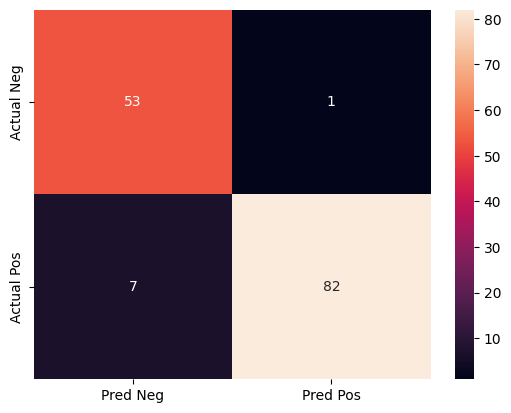

In [38]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

# Receiver Operating Characteristics (ROC) Curve

* ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. 

* ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

# What is TPR and FPR?
 
 * TPR: Of all the things that are truly positive, how many of them did I correctly predict as positive?
 $$
 \text{TPR} = \frac{TP}{TP + FN}
 $$
 * FPR: Of all the things that are truly negative, how many of them did I falsely predict as positive?
 $$
 \text{FPR} = \frac{FP}{FP + TN}
 $$






In [39]:
# A quick computation using the confusion matrix above. 
TPR = None # DO later
FPR = None # TODO

In [40]:
from ipywidgets import interactive, fixed
import sklearn.metrics as metrics

In [41]:
probas_pred = model.predict_proba(X_test)[:,1] 
fprs, tprs, thresholds = metrics.roc_curve(y_test, probas_pred)

In [42]:
def roc(threshold, probas_pred, y_test, fprs, tprs):
    
    y_pred = probas_pred>=threshold

    fpr = sum(y_pred*(1-y_test))/sum(y_test == 0) 
 
    print('fpr: '+str(round(fpr,2)))

    tpr = sum(y_pred*y_test)/y_test.sum()
 
    print('tpr: '+str(round(tpr,2)))

    # dashed line 
    x_dashed = np.linspace(0, 1, num=len(fprs))
    plt.plot(fprs, tprs)
    plt.plot(x_dashed, x_dashed, linestyle='dashed', color='gray')
    plt.plot(fpr, tpr,'ro')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)

In [43]:
interactive_plot = interactive(roc, threshold=(0,1,0.001), probas_pred=fixed(probas_pred), y_test=fixed(y_test),
                               fprs=fixed(fprs), tprs=fixed(tprs))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.001), Output()), _dom_cl…

# Compare Classifiers

* Area under Curve (AUC) calculates the area under the ROC curve.  It is a single number that serves as a measure of aggregated classification performance. 


* A random guessing classifier that predict class +1 with probability 0.5 would have AUC 0.5.

* A good classifier should have AUC as close to 1 as possible and should have AUC at least 0.5.

In [44]:
print("area under the curve is : %.5f" % metrics.auc(fprs, tprs))
print("area under the curve use another function is : %.5f" % metrics.roc_auc_score(y_test, probas_pred))

area under the curve is : 0.98200
area under the curve use another function is : 0.98200


# Precision and Recall

This is the criterion people usually used in Machine Learning.
* Precision: Of the ones I predicted positive, how many of them were actually positive?
$$
\text{precision} = \frac{TP}{TP + FP} \\
$$

* Recall: Same definition as TPR.
$$
\text{recall} = \frac{TP}{TP + FN}
$$

* F1-score:
$$
F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$


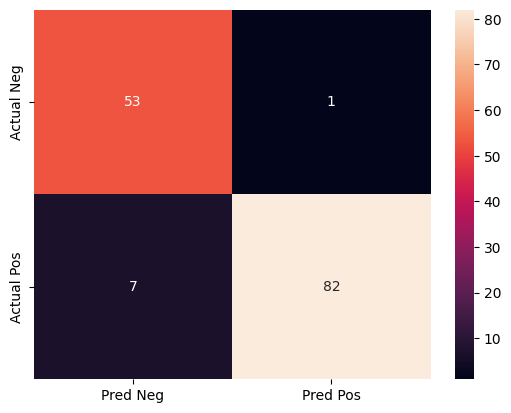

In [45]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [48]:
# A quick computation using the confusion matrix above. 
Recall = 53/(53+1)# TODO
Precision = 53/(53+7)

# Precision and Recall Curve

PR curve is created by plotting the **precision** against **recall** at various threshold settings. 

In [49]:
p, r, thresholds = metrics.precision_recall_curve(y_test, probas_pred)

def pr(threshold, probas_pred, y_test, r, p):
    
    y_pred = probas_pred>=threshold
    if y_pred.sum()>0:
      precision = sum(y_pred*y_test)/y_pred.sum()
    else:
      precision = 1
    print('precision: '+str(round(precision,2)))
    if y_test.sum()>0:
      recall = sum(y_pred*y_test)/y_test.sum()
    else:
      recall = 1
    print('recall: '+str(round(recall,2)))

    plt.plot(r,p)
    plt.plot(recall,precision,'ro')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)

interactive_plot = interactive(pr, threshold=(0,1,0.001), probas_pred=fixed(probas_pred), y_test=fixed(y_test),
                               r=fixed(r), p=fixed(p))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.001), Output()), _dom_cl…

# Regularization for logistic Regression: $l_1$ and $l_2$ penalty

Notice above I set the logistic regression model as `LogisticRegression(penalty = 'none')` to get the Maximum likelihood estimate of $\beta$.

The default in sklearn for `LogisticRegression` uses an $l_2$ penalty, just like ridge regression in the linear regression case.

In this case, the loss function could be viewed as the negative log-likelihood function, plus a penalty term. 
$$
\hat{\beta} = \arg\min_{w} -\frac{1}{n}l_n(\beta) + \lambda \|\beta\|^2
$$

Let's train the breast cancer dataset again.

In [35]:
# Create and train logistic regression model
model_l2 = LogisticRegression(penalty = 'l2', C=1/10.0) # default for "penalty" argument is l2 penalty.
model_l2.fit(X_train,y_train)

LogisticRegression(C=0.1)

In [36]:
print(model_l2.score(X_train, y_train)) # obtained slightly better accuracy

0.9788732394366197


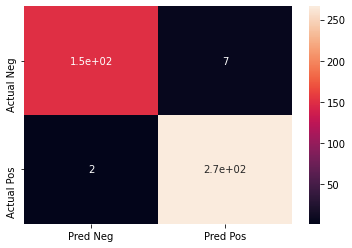

In [37]:
y_pred = model_l2.predict(X_train)
plot_confusion_matrix(confusion_matrix(y_train, y_pred))

In [38]:
probas_pred = model_l2.predict_proba(X_test)[:,1] 
fprs, tprs, thresholds = metrics.roc_curve(y_test, probas_pred)
interactive_plot = interactive(roc, threshold=(0,1,0.001), probas_pred=fixed(probas_pred), y_test=fixed(y_test),
                               fprs=fixed(fprs), tprs=fixed(tprs))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.001), Output()), _dom_cl…

In [39]:
# The AUC now is super close to 1!
print("area under the curve is : %.5f" % metrics.auc(fprs, tprs)) 

area under the curve is : 0.99834


In [42]:
# Precision and Recall Curve
p, r, thresholds = metrics.precision_recall_curve(y_test, probas_pred)
interactive_plot = interactive(pr, threshold=(0,1,0.01), probas_pred=fixed(probas_pred), y_test=fixed(y_test),
                               r=fixed(r), p=fixed(p))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…